### Splitting the Dataset 

In [28]:
import splitfolders

input_folder = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet"

splitfolders.ratio(input_folder, output="D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)


Copying files: 9570 files [00:04, 2163.06 files/s]


### Importing required libraries

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns

In [30]:
TRAIN_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/train"
VAL_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/val"
TEST_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/test"

### Initializing Image Size

In [31]:
IMAGE_SIZE = (128, 128)

### Initializing train, validation & test data

In [32]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE
)


Found 6698 files belonging to 4 classes.
Found 1914 files belonging to 4 classes.
Found 958 files belonging to 4 classes.


### Plot Images with labels

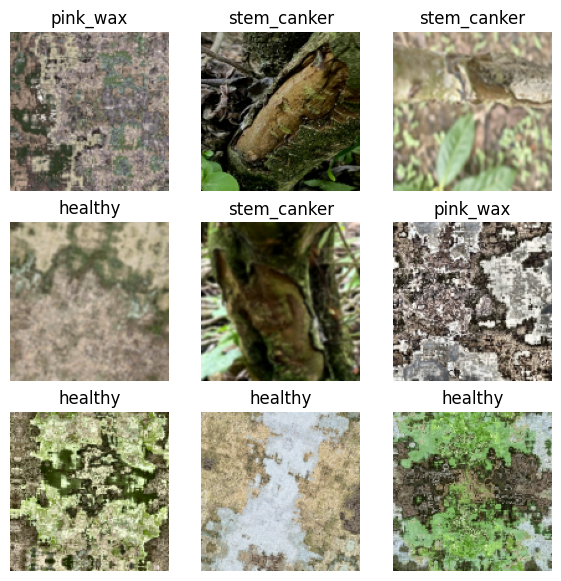

In [33]:
plt.figure(figsize=(7, 7))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [34]:
class_num = 2
input_shape = (128,128,3)

### Import model for Transfer Learning

In [35]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=class_num
)

In [36]:
efficientnet.summary() 

Model: "efficientnetb1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 6,513,184 (24.85 MB)

 Non-trainable params: 62,055 (242.41 KB)

### Freeze layerns in EfficientNetB1

In [37]:
for layer in efficientnet.layers[:-5]:
    layer.trainable = False

In [38]:
for layer in efficientnet.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
rescaling_2 False
normalization_1 False
rescaling_3 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn F

### Building the classification model

In [39]:
inputs = tf.keras.Input(shape=input_shape, name='image_input')

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = efficientnet(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(.3)(x)
outputs = Dense(class_num, activation='softmax')(x)

effnet_model = tf.keras.Model(inputs, outputs, name='output')

### Compile the model

In [40]:
effnet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(effnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
mc = ModelCheckpoint('EfficentNet_Tea_Stem_classification.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Fit the model
history_effnet = effnet_model.fit(
    training_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=32,
    callbacks=[es, mc]
)

TypeError: ModelCheckpoint.__init__() got an unexpected keyword argument 'save_format'

### Train, Validation & Test accuracy from saved model

In [ ]:
from keras.models import load_model
saved_model = load_model('best_model_eye_classification.h5')

train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')

### Plot Accuracy & Loss graphs

In [ ]:
fig1 = plt.gcf()
plt.plot(history_effnet.history['accuracy'])
plt.plot(history_effnet.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history_effnet.history['loss'])
plt.plot(history_effnet.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predictions on Test data

In [20]:
prediction_effnet = saved_model.predict(test_ds) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [28]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [ ]:
print(type(prediction_effnet))
print(type(correct_labels))

### F1- Score, Precision & Recall

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, prediction_effnet))

### Confusion Matrix

In [ ]:
cm = confusion_matrix(correct_labels, prediction_effnet)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### Add labels to an array

In [ ]:
class_names = []

for directory in glob.glob("D:/Tasks/Drowsy_Detection/Eyes_Dataset_split/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

### Using the model for classification

In [3]:
from keras.models import load_model

load_imagePath = 'C:/Users/Athindu/Downloads/gettyimagesn.jpg'
saved_model = load_model('best_model_eye_classification.h5')

In [ ]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = IMAGE_SIZE) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))